In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 3.0MB/s 
     |████████████████████████████████| 3.3MB 17.7MB/s 
     |████████████████████████████████| 901kB 30.6MB/s 


In [ ]:
import json
PATH = "/content/drive/MyDrive/NLP/"
f = open(PATH + "multiple_choice_92sim.json",)
data = json.load(f)

print(len(data))
f.close()

3441


In [ ]:
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "multiple_choice_92sim.json",)
data = json.load(f)

print(len(data))
f.close()

3441


In [5]:
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "labeled_pairs_3_15.json",)
data_2 = json.load(f)

print(len(data_2))
f.close()

5000


In [3]:
from sklearn.model_selection import train_test_split

In [ ]:
# train_texts, test_texts = train_test_split(data, test_size=.1)
# with open(PATH + 'data/train.json', 'w') as f:
#   json.dump(train_texts, f)

# with open(PATH + 'data/test.json', 'w') as f:
#   json.dump(test_texts, f)

In [6]:
DATAPATH = PATH + 'data/noisy_train.json'
def get_data(path=DATAPATH):

  question_list = list()
  expo_list = list()

  with open(DATAPATH) as f:
    data = list(json.load(f))
  
  for question, expo in data:
    question_list.append(question)
    expo_list.append(expo[0])

  return question_list, expo_list

In [7]:
question_list, expo_list = get_data()
print(len(question_list))

3151


In [ ]:
import torch
import transformers
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, length):
        self.encodings = encodings
        self.labels = labels
        self.length = length

    def __getitem__(self, idx):
        encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label_item = {key: torch.tensor(val[idx]) for key, val in self.labels.items()}
        return encoding_item, label_item

    def __len__(self):
        return self.length

def get_dataset(question_list, expo_list):
    from sklearn.model_selection import train_test_split
    from transformers import BartTokenizerFast

    train_qs, val_qs, train_es, val_es = train_test_split(question_list, expo_list, test_size=.1)

    tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')

    train_q_encodings = tokenizer(train_qs, truncation=True, padding=True)
    val_q_encodings = tokenizer(val_qs, truncation=True, padding=True)

    train_e_encodings = tokenizer(train_es, truncation=True, padding=True)
    val_e_encodings = tokenizer(val_es, truncation=True, padding=True)

    train_dataset = IMDbDataset(train_e_encodings,train_q_encodings, length = len(train_qs))
    val_dataset = IMDbDataset(val_e_encodings, val_q_encodings, length=len(val_qs))

    return train_dataset, val_dataset

In [ ]:
train_dataset, val_dataset = get_dataset(question_list, expo_list)

In [ ]:
print(len(train_dataset))

2786


In [ ]:
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss

from torch.utils.data import DataLoader
from transformers import BartForConditionalGeneration, AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

model =  BartForConditionalGeneration.from_pretrained('facebook/bart-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

True
cuda


In [ ]:
WEIGHT_PATH = PATH + 'weights/noisy_bart'

In [ ]:
def train(epochs=10):
    train_loss_set = list()
    for epoch in range(epochs):
        for batch in train_loader:
            input, label = batch

            optim.zero_grad()

            input_ids = input['input_ids'].to(device)
            attention_mask = input['attention_mask'].to(device)

            labels = label['input_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            # loss_func = BCEWithLogitsLoss()
            # loss = loss_func(logits, labels)  # convert labels to float for calculation
            # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
            train_loss_set.append(loss.item())

            # Backward pass
            loss.backward()

            optim.step()

        print("Finished epoch {}".format(epoch))

    model.save_pretrained(WEIGHT_PATH)
    return train_loss_set

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Finished epoch 9


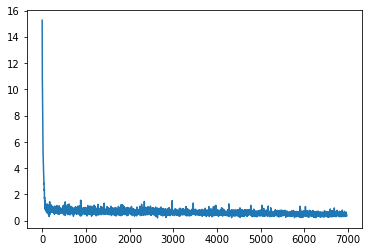

In [ ]:
loss_values = train(10)

import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.show()

In [ ]:
model = BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        

In [ ]:
DATAPATH = PATH + 'data/clean_test.json'
import torch
from transformers import BartTokenizerFast
tokenizer = BartTokenizerFast.from_pretrained('facebook/bart-base')
def get_data(path=DATAPATH):

  question_list = list()
  expo_list = list()

  with open(DATAPATH) as f:
    data = list(json.load(f))
  
  for question, expo in data:
    question_list.append(question)
    expo_list.append(expo[0])

  return question_list, expo_list
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, expos, labels, length):
      self.encodings = encodings
      self.expos = expos
      self.labels = labels
      self.length = length

  def __getitem__(self, idx):
      encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      return (encoding_item, self.labels[idx], self.expos[idx])

  def __len__(self):
      return self.length

def get_dataset(question_list, expo_list):

  expo_encodings = tokenizer(expo_list, truncation=True, padding=True)

  test_dataset = TestDataset(expo_encodings, expo_list, question_list,length = len(question_list))

  return test_dataset

In [ ]:
question_list, expo_list = get_data()
test_dataset = get_dataset(question_list, expo_list)

In [ ]:
from transformers.datasets import load_metric 
metric = load_metric("bertscore")


ModuleNotFoundError: ignored

In [ ]:
from transformers import BartForConditionalGeneration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

def validate(val_dataset):
    model =  BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
    model.to(device)
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

    print("Evaluating on {} questions".format(len(val_dataset)))

    list_of_references = list()
    list_of_hypotheses = list()
    list_of_original = list()
    list_of_pp = list()

    count = 0
    for batch in val_loader:
        input, label, orig = batch
        input_ids = input['input_ids'].to(device)
        attention_mask = input['attention_mask'].to(device)

        with torch.no_grad():
            generated_sequences = model.generate(
                input_ids=input_ids,
                do_sample=True,
                max_length=600,
                temperature=1.0,
                top_k=5,
                top_p=0.9,
                repetition_penalty=1.0,
                )
            #print(generated_sequences)
            #print(label)
            reference = label[0].split()
            for sequence in generated_sequences:
                text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
                #hypothesis = text.split()
                '''
                if text != '</s>' or text != '<s>' or text != '<pad>':
                  hypothesis += text
                '''
                text = text.replace('</s>', '')
                text = text.replace('<s>', '')
                text = text.replace('<pad>', '')

                hypothesis = text.split()
                #print(text)

                #perplexity
                token = tokenizer(text, return_tensors='pt')
                ppl = get_ppl(token)
                #print(pp_score)
                list_of_pp.append(ppl)
                # Prints out sequences
            #print(hypothesis)

            list_of_hypotheses.append(hypothesis)
            list_of_references.append([reference])
            list_of_original.append(orig)
        print(count)
        count += 1
            
    # Calculate BLEU Score
    import nltk
    score = nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)

    return list_of_references, list_of_hypotheses,list_of_original, score, list_of_pp
      # import torchtext

      #   score = torchtext.data.metrics.bleu_score(candidate_corpus, references_corpus)

In [ ]:
def get_ppl(encodings):
  max_length = 600
  stride = 300

  lls = []
  for i in range(0, encodings.input_ids.size(1), stride):
      begin_loc = max(i + stride - max_length, 0)
      end_loc = min(i + stride, encodings.input_ids.size(1))
      trg_len = end_loc - i    # may be different from stride on last loop
      input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
      target_ids = input_ids.clone()
      target_ids[:,:-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)
          log_likelihood = outputs[0] * trg_len

      lls.append(log_likelihood)

  ppl = torch.exp(torch.stack(lls).sum() / end_loc)
  return ppl

In [ ]:
list_of_references, list_of_hypotheses, list_of_original, score, list_of_pp = validate(test_dataset)

Evaluating on 300 questions
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [ ]:
print(len(list_of_pp))

300


In [ ]:
print(score)

0.017503426341486085


In [ ]:
from datasets import load_metric
import bert_score
metric = load_metric("bertscore")

In [ ]:
lis_of_h = []
lis_of_r = []
for i in tqdm(range(len(list_of_hypotheses))):
  h = list_of_hypotheses[i][0]
  r = ' '.join(list_of_references[i][0])
  lis_of_h.append(h)
  lis_of_r.append(r)

In [ ]:
P, R, F1 = bert_score.score(lis_of_h, lis_of_r, lang='en', verbose=True)


calculating scores...
computing bert embedding.



computing greedy matching.



done in 1.54 seconds, 39.09 sentences/sec


In [ ]:
print(F1)
print(f"System level F1 score: {F1.mean():.3f}")
print(f"System level Precision: {P.mean():.3f}")
print(f"System level Recall: {R.mean():.3f}")

tensor([0.8448, 0.8449, 0.8345, 0.7801, 0.8470, 0.8307, 0.7816, 0.7749, 0.7729,
        0.7731, 0.8429, 0.8385, 0.8500, 0.7749, 0.8423, 0.8353, 0.8477, 0.7777,
        0.8456, 0.8406, 0.8468, 0.8388, 0.7809, 0.8344, 0.8436, 0.8474, 0.7795,
        0.7852, 0.8467, 0.8421, 0.8381, 0.8645, 0.8615, 0.8405, 0.8522, 0.7742,
        0.8435, 0.8533, 0.7797, 0.8628, 0.7866, 0.7793, 0.7811, 0.8380, 0.7763,
        0.8414, 0.8535, 0.7725, 0.8441, 0.8408, 0.7861, 0.8723, 0.7676, 0.7956,
        0.8409, 0.7714, 0.8533, 0.7869, 0.8492, 0.7726])
System level F1 score: 0.820
System level Precision: 0.875
System level Recall: 0.773


In [ ]:
print(list_of_pp[0].item())

1.7218959331512451


In [ ]:
sum = 0
for i in range(len(list_of_pp)):
  sum += list_of_pp[i].item()
print(sum/300)

1.758521210749944


In [ ]:
from tqdm.notebook import tqdm
model =  BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
model.to(device)
generated_sen = []

for i in tqdm(range(0,3441)):
  sentence = data[i][1][0]
  tokenize_input = tokenizer.tokenize(sentence)
  tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)]).to(device)
  a = model.generate(tensor_input,
                do_sample=True,
                max_length=600,
                temperature=1.0,
                top_k=5,
                top_p=0.9,
                repetition_penalty=1.0,
                )
  text = ''
  for w in a:
    text += tokenizer.decode(w, clean_up_tokenization_spaces=True)
  generated_sen.append(text)
  #print(text)
'''
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "generated_sentences.json",'w')
json.dump(generated_sen, f)

f.close()
'''

In [ ]:
print(len(generated_sen))

3441


In [ ]:
print(generated_sen[7])

</s><s>Hi, good morning. Thanks for taking my question. I wanted to follow-up on OptumInsight’s operating margin guidance. So, you’re guiding to about 25% operating margin in fiscal ‘19. You’ve got OptumRx now at 20%, OptumNow at 20%. So, I’m just trying to get a sense of how much of that is coming from Optum insight versus Optum Insight? And then, my second question is just around the Optum business. I think, historically, Optum has been in the mid-single-digit operating margin range for a couple of years, but now, you are moving closer to the upper end of that range. And I was just wondering if you could give us a little bit more color on what you think is driving that relative to your long-term target of 30% to 40% operating margins? Thank you.</s>


In [ ]:
print(list_of_pp)

[tensor(3123.8684, device='cuda:0'), tensor(722.2648, device='cuda:0')]


In [ ]:
print(score)

0


In [ ]:
from pprint import pprint

In [ ]:
for i in range(len(list_of_references)):
  print("Original:")
  print(list_of_original[i])
  print("Ground Truth:")
  print(' '.join(list_of_references[i][0]))
  print("Generated: ")
  print(list_of_hypotheses[i])
  print("-------------------------------")

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from tqdm.notebook import tqdm
device = 'cuda:0'
model_id = 'gpt2-large'
gpt_model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

KeyboardInterrupt: ignored

In [ ]:
import math
import torch
!pip install pytorch_pretrained_bert
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
# Load pre-trained model (weights)
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

     |████████████████████████████████| 133kB 12.0MB/s 
     |████████████████████████████████| 133kB 20.3MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 7.3MB 18.5MB/s 
ERROR: botocore 1.20.35 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


100%|██████████| 458495/458495 [00:00<00:00, 1281637.38B/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [ ]:
def score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss=model(tensor_input, lm_labels=tensor_input)
    return math.exp(loss)

a = ["i wrote a book, i wrote a book, i wrote a book, i wrote a book,i wrote a book, i wrote a book.",
   "i wrote a book.",
   "i wrote a book about the life of two young people who fall in love with each other."]
     
print([score(i) for i in a])

TypeError: ignored

In [ ]:
def pp_score(model, sentence,  mask_token_id=103):
  tensor_input = sentence
  repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
  mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
  masked_input = repeat_input.masked_fill(mask == 1, 103)
  labels = repeat_input.masked_fill( masked_input != 103, -100)
  loss,_ = model(masked_input, masked_lm_labels=labels)
  result = np.exp(loss.item())
  return result